### Importar libreria

In [27]:
from libreria import *
from pathlib import Path

RAW_DIR = Path("./data/raw")      # <‑‑ coloca los ZIP/CSV descargados aquí
PREP_DIR = Path("./data/processed")
PREP_DIR.mkdir(parents=True, exist_ok=True)

### Estandarización y normalización de variables numéricas

In [28]:
df = pl.read_csv(PREP_DIR / "dataset_II_Clean.csv")
df.head()

DPTO_MPIO,ANO_CENSO,TRIMESTRE,DESTINO2,ESTADO_ACT,ESTRATO,LOCALIDAD2,AMPLIACION,OB_FORMAL,USO,USO_DOS,AREATOTZC,SIS_CONSTR,MANO_OBRAP,MANO_OBRAT,MANO_OBRAF,AREAVENDIB,NUMUNIDEST,NUMUNIVEN,NUMUNIXVEN,NRO_EDIFIC,NRO_PISOS,CAPITULO,GRADOAVANC,TIPOVRDEST,PRECIOVTAX,AREATOTCO2,AREAVENUNI,RANVIVI,LIC_RADICADO_SN,C1_EXCAVACION,C1_CIMENTACION,C1_DESAGUES,C2_ESTRUCTURA,C2_INST_HIDELEC,C2_CUBIERTA,C3_MAMPOSTERIA,C3_PANETE,C4_PISO_ENCHAPE,C4_CARP_METALICA,C4_CARP_MADERA,C4_CIELO_RASO,C5_VID_CERRAJERIA,C5_PINTURA,C6_REM_EXTERIORES,C6_REM_ACABADOS,C6_ASEO,UNI_DEC_NOVIS,UNIDEC_RANVIVI_1,UNIDEC_RANVIVI_2,UNIDEC_RANVIVI_3,UNIDEC_RANVIVI_4,UNIDEC_RANVIVI_5,UNIDEC_RANVIVI_6,AREA_RANVIVI_1,AREA_RANVIVI_2,AREA_RANVIVI_3,AREA_RANVIVI_4,AREA_RANVIVI_5,AREA_RANVIVI_6,AREA_NOVIS,MOVIMIENTO_ENC,ANIO_MESINICIO
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64
13001,2007,3,1,1,6,1,1,2,1,0,2600.0,1,5,99,0.0,15130.0,111,0,13,0,1,2,40,2,2200.0,17730,136.306306,6,2,100.0,100.0,100.0,40.0,40.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111,0,0,0,0,0,111,0.0,0.0,0.0,0.0,0.0,17730.0,17730.0,1,2007
17001,2007,3,5,1,4,7,2,2,2,3,0.0,5,1,2,0.0,150.0,1,0,0,0,1,5,80,1,1300.0,150,150.0,0,2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,80.0,80.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2007
41001,2007,3,4,1,2,10,2,2,2,3,0.0,3,0,1,3.0,60.0,1,0,0,1,1,3,77,1,250.0,60,60.0,1,2,100.0,100.0,100.0,100.0,100.0,100.0,77.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2007
50001,2007,3,4,1,6,2,2,2,1,0,105.0,2,15,25,0.0,3876.0,46,0,0,46,1,3,95,1,1500.0,3981,84.26087,5,2,100.0,100.0,100.0,100.0,100.0,100.0,95.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,0,0,0,0,46,0,0.0,0.0,0.0,0.0,3981.0,0.0,3981.0,1,2006
52001,2007,3,1,1,5,9,2,2,1,0,165.0,1,26,6,0.0,1104.0,12,8,0,0,1,4,15,2,1029.0,1269,92.0,5,2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,15.0,15.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,12,0,0,0,0,12,0,0.0,0.0,0.0,0.0,1269.0,0.0,1269.0,1,2007


In [29]:
df.estimated_size("gb")

1.303695872426033

In [30]:
num_cols = [
    col for col, dtype in zip(df.columns, df.dtypes)
    if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64, pl.Float32, pl.Float64)
]
len(num_cols) # todas las columnas numéricas

63

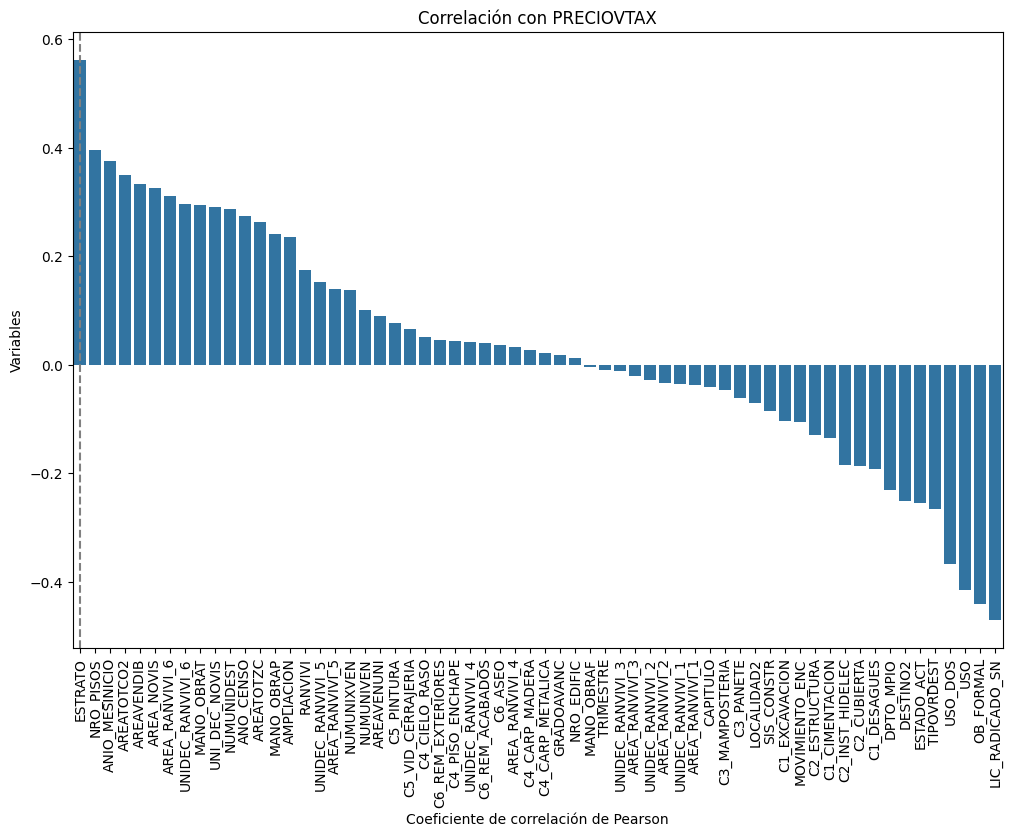

In [31]:
TARGET = "PRECIOVTAX"          # ← cambia aquí si tu objetivo se llama distinto
plot_correlation_matrix(
    df,
    num_cols,
    target=TARGET
)

In [32]:
pct_cols   = [c for c in df.columns if c.startswith(tuple(f"C{i}_" for i in range(1,7)))] + ["GRADOAVANC"]

area_cols  = ["AREATOTCO2", "AREATOTZC", "AREAVENUNI", "AREAVENDIB"] + \
             [c for c in df.columns if c.startswith("AREA_")]

count_cols = ["UNI_DEC_NOVIS", "NUMUNIDEST", "NUMUNIVEN", "NUMUNIXVEN"] + \
             [c for c in df.columns if c.startswith("UNIDEC_RANVIVI_")]

cat_cols   = ["DPTO_MPIO", "ESTRATO", "DESTINO2", "ESTADO_ACT", "SIS_CONSTR",
              "USO", "USO_DOS", "RANVIVI", "TIPOVRDEST", "TRIMESTRE"]

bin_cols   = ["AMPLIACION", "OB_FORMAL", "LIC_RADICADO_SN"]


In [33]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib
import numpy as np
import pandas as pd

In [34]:
def pct_transform(x):
    return x / 100.0
pct_tf   = FunctionTransformer(pct_transform, feature_names_out="one-to-one")

In [35]:
area_scaler  = StandardScaler()
count_scaler = StandardScaler()

In [36]:
cat_tf  = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

In [ ]:
preproc = ColumnTransformer(
    transformers=[
        ("pct",   pct_tf,           pct_cols), # ÷100 + StandardScaler
        ("area",  area_scaler,      area_cols), # log1p + StandardScaler
        ("cnt",   count_scaler,     count_cols), # log1p + StandardScaler
        ("bin",   "passthrough",    bin_cols), # 0/1 tal cual
        ("cat",   cat_tf,           cat_cols) # One-Hot
    ],
    remainder="drop",
    n_jobs=-1
)

In [38]:
y_scaler = StandardScaler()

In [39]:
artifacts_dir = Path("./logs")
artifacts_dir.mkdir(exist_ok=True)
joblib.dump(preproc, artifacts_dir/"feature_pipeline.joblib")
joblib.dump(y_scaler, artifacts_dir/"y_scaler.joblib")

['logs\\y_scaler.joblib']

In [40]:
df.head()

DPTO_MPIO,ANO_CENSO,TRIMESTRE,DESTINO2,ESTADO_ACT,ESTRATO,LOCALIDAD2,AMPLIACION,OB_FORMAL,USO,USO_DOS,AREATOTZC,SIS_CONSTR,MANO_OBRAP,MANO_OBRAT,MANO_OBRAF,AREAVENDIB,NUMUNIDEST,NUMUNIVEN,NUMUNIXVEN,NRO_EDIFIC,NRO_PISOS,CAPITULO,GRADOAVANC,TIPOVRDEST,PRECIOVTAX,AREATOTCO2,AREAVENUNI,RANVIVI,LIC_RADICADO_SN,C1_EXCAVACION,C1_CIMENTACION,C1_DESAGUES,C2_ESTRUCTURA,C2_INST_HIDELEC,C2_CUBIERTA,C3_MAMPOSTERIA,C3_PANETE,C4_PISO_ENCHAPE,C4_CARP_METALICA,C4_CARP_MADERA,C4_CIELO_RASO,C5_VID_CERRAJERIA,C5_PINTURA,C6_REM_EXTERIORES,C6_REM_ACABADOS,C6_ASEO,UNI_DEC_NOVIS,UNIDEC_RANVIVI_1,UNIDEC_RANVIVI_2,UNIDEC_RANVIVI_3,UNIDEC_RANVIVI_4,UNIDEC_RANVIVI_5,UNIDEC_RANVIVI_6,AREA_RANVIVI_1,AREA_RANVIVI_2,AREA_RANVIVI_3,AREA_RANVIVI_4,AREA_RANVIVI_5,AREA_RANVIVI_6,AREA_NOVIS,MOVIMIENTO_ENC,ANIO_MESINICIO
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64
13001,2007,3,1,1,6,1,1,2,1,0,2600.0,1,5,99,0.0,15130.0,111,0,13,0,1,2,40,2,2200.0,17730,136.306306,6,2,100.0,100.0,100.0,40.0,40.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111,0,0,0,0,0,111,0.0,0.0,0.0,0.0,0.0,17730.0,17730.0,1,2007
17001,2007,3,5,1,4,7,2,2,2,3,0.0,5,1,2,0.0,150.0,1,0,0,0,1,5,80,1,1300.0,150,150.0,0,2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,80.0,80.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2007
41001,2007,3,4,1,2,10,2,2,2,3,0.0,3,0,1,3.0,60.0,1,0,0,1,1,3,77,1,250.0,60,60.0,1,2,100.0,100.0,100.0,100.0,100.0,100.0,77.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2007
50001,2007,3,4,1,6,2,2,2,1,0,105.0,2,15,25,0.0,3876.0,46,0,0,46,1,3,95,1,1500.0,3981,84.26087,5,2,100.0,100.0,100.0,100.0,100.0,100.0,95.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46,0,0,0,0,46,0,0.0,0.0,0.0,0.0,3981.0,0.0,3981.0,1,2006
52001,2007,3,1,1,5,9,2,2,1,0,165.0,1,26,6,0.0,1104.0,12,8,0,0,1,4,15,2,1029.0,1269,92.0,5,2,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,15.0,15.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,12,0,0,0,0,12,0,0.0,0.0,0.0,0.0,1269.0,0.0,1269.0,1,2007


In [41]:
TARGET = "PRECIOVTAX"
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor

X = df.drop(TARGET)
y = df.select(TARGET).to_numpy().reshape(-1, 1)   # 2-dim para StandardScaler

# 1. Split
X_train, X_val, y_train_raw, y_val_raw = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=df["TRIMESTRE"]
)

In [42]:
X_train.shape, X_val.shape, y_train_raw.shape, y_val_raw.shape

((2221956, 62), (555490, 62), (2221956, 1), (555490, 1))

In [43]:
preproc.fit(X_train.to_pandas())
y_scaler.fit(y_train_raw)

StandardScaler()

In [44]:
# 4. Transformar
X_train_trans = preproc.transform(X_train)
X_val_trans   = preproc.transform(X_val)

In [45]:
y_train = y_scaler.transform(y_train_raw).ravel()
y_val   = y_scaler.transform(y_val_raw).ravel()

In [46]:
# 5. Modelo
model = LGBMRegressor(
    n_estimators=800, learning_rate=0.05,
    subsample=0.8, colsample_bytree=0.8, random_state=42
)
model.fit(X_train_trans, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6146
[LightGBM] [Info] Number of data points in the train set: 2221956, number of used features: 178
[LightGBM] [Info] Start training from score -0.000000


LGBMRegressor(colsample_bytree=0.8, learning_rate=0.05, n_estimators=800,
              random_state=42, subsample=0.8)

In [21]:
from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor(n_estimators=10,max_depth=15, random_state=42, n_jobs=-1)
model1.fit(X_train_trans, y_train)

RandomForestRegressor(max_depth=15, n_estimators=10, n_jobs=-1, random_state=42)

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_regression_model(model, y_scaler, X_val_trans, y_val_raw, print_results=True):
    """
    Evaluate a regression model using scaled validation data and return metrics.
    
    Parameters:
    -----------
    model : trained model instance
        The trained model with a predict method
    y_scaler : scaler instance
        Scaler used to transform target variable
    X_val_trans : array-like
        Transformed validation features
    y_val_raw : array-like
        Raw (unscaled) validation target values
    print_results : bool, default=True
        Whether to print the evaluation metrics
        
    Returns:
    --------
    dict
        Dictionary containing evaluation metrics
    """
    # Get predictions and inverse transform
    y_pred_scaled = model.predict(X_val_trans)
    y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
    
    # Calculate metrics
    mae = mean_absolute_error(y_val_raw, y_pred)
    mse = mean_squared_error(y_val_raw, y_pred)
    r2 = r2_score(y_val_raw, y_pred)
    
    # Store metrics
    metrics = {
        'MAE': mae,
        'MSE': mse,
        'R2': r2,
        'y_pred': y_pred  # Optional: return predictions for further analysis
    }
    
    # Print results if requested
    if print_results:
        print(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.3f}")
    
    return metrics

In [23]:
metrics = evaluate_regression_model(model, y_scaler, X_val_trans, y_val_raw)
print("MAE (miles COP/m²):", metrics['MAE'])

c:\Users\JemyC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE: 300.16, MSE: 287586.35, R2: 0.825
MAE (miles COP/m²): 300.1611898190872


In [24]:
metrics = evaluate_regression_model(model1, y_scaler, X_val_trans, y_val_raw)
print("MAE (miles COP/m²):", metrics['MAE'])

MAE: 308.68, MSE: 277913.52, R2: 0.831
MAE (miles COP/m²): 308.6828041027872


In [25]:
import cloudpickle
import joblib
from pathlib import Path

In [21]:
def save_model_artifacts(preproc, y_scaler, model, artifacts_path="./model_artifacts", model_name="lgbm_reg"):
    """
    Guarda el preprocesador, el escalador y el modelo entrenado en la ruta especificada.
    
    Parameters:
    -----------
    preproc : ColumnTransformer
        El preprocesador de características
    y_scaler : StandardScaler
        El escalador para la variable objetivo
    model : trained model
        El modelo entrenado
    artifacts_path : str or Path
        La ruta donde se guardarán los artefactos
    model_name : str
        El nombre base para el archivo del modelo
    
    Returns:
    --------
    Path
        La ruta donde se guardaron los artefactos
    """
    # Convertir a Path y crear directorio si no existe
    artifacts_dir = Path(artifacts_path)
    artifacts_dir.mkdir(parents=True, exist_ok=True)
    
    # Guardar preproc y y_scaler usando cloudpickle para evitar problemas de pickling con funciones locales
    with open(artifacts_dir/"feature_pipeline.joblib", "wb") as f:
        cloudpickle.dump(preproc, f)
    
    with open(artifacts_dir/"y_scaler.joblib", "wb") as f:
        cloudpickle.dump(y_scaler, f)
    
    # Guardar el modelo con joblib
    joblib.dump(model, artifacts_dir/f"{model_name}.joblib")
    
    print(f"✅ Pipeline, scaler y modelo guardados en {artifacts_dir}")
    
    return artifacts_dir

In [27]:
# Ejemplo de uso
ruta_guardado = "./modelos/Prueba_II"
save_model_artifacts(preproc, y_scaler, model, ruta_guardado, "lgbm_reg")
# Guardar el modelo de RandomForestRegressor
save_model_artifacts(preproc, y_scaler, model1, ruta_guardado, "rf_reg")

✅ Pipeline, scaler y modelo guardados en modelos\Prueba_II
✅ Pipeline, scaler y modelo guardados en modelos\Prueba_II


WindowsPath('modelos/Prueba_II')

### modelos

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
import pandas as pd

models = {
    "LGBM": LGBMRegressor(n_estimators=800, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42),
    "RandomForest": RandomForestRegressor(n_estimators=10, max_depth=15, random_state=42, n_jobs=-1),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=800, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
}

cv = KFold(n_splits=2, shuffle=True, random_state=42)
results = {}

In [51]:
from pathlib import Path
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score, explained_variance_score,
                             make_scorer)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib


# --- Scorers que devuelven métricas EN ESCALA ORIGINAL -------------
def _mae_unscaled(y_true_s, y_pred_s, scaler):
    y_t = scaler.inverse_transform(y_true_s.reshape(-1, 1)).ravel()
    y_p = scaler.inverse_transform(y_pred_s.reshape(-1, 1)).ravel()
    return mean_absolute_error(y_t, y_p)

def _rmse_unscaled(y_true_s, y_pred_s, scaler):
    y_t = scaler.inverse_transform(y_true_s.reshape(-1, 1)).ravel()
    y_p = scaler.inverse_transform(y_pred_s.reshape(-1, 1)).ravel()
    return np.sqrt(mean_squared_error(y_t, y_p))

def _r2_unscaled(y_true_s, y_pred_s, scaler):
    y_t = scaler.inverse_transform(y_true_s.reshape(-1, 1)).ravel()
    y_p = scaler.inverse_transform(y_pred_s.reshape(-1, 1)).ravel()
    return r2_score(y_t, y_p)


def train_evaluate_regression_models(models, X_train_trans, y_train,
                                     X_val_trans, y_val_raw, y_scaler,
                                     artifacts_dir=None, save_models=True,
                                     cv_folds: int = 0, random_state: int = 42):
    """
    Entrena y evalúa múltiples modelos de regresión con comparación hold-out
    y validación cruzada opcional.

    Parameters
    ----------
    ...
    cv_folds : int, default=0
        Si >1 se realiza K-Fold con ese número de particiones sobre el set
        de entrenamiento y se reportan las métricas medias ± std.
    random_state : int, default=42
        Semilla para la división K-Fold reproducible.

    Returns
    -------
    pd.DataFrame
        Métricas comparativas por modelo (hold-out y, opcionalmente, CV).
    """
    # -----------------------------------------------------------------
    # Preparativos
    # -----------------------------------------------------------------
    if save_models and artifacts_dir is not None:
        artifacts_dir = Path(artifacts_dir)
        artifacts_dir.mkdir(parents=True, exist_ok=True)

    model_metrics = {}          # resultados finales
    all_predictions = {}        # para gráficos hold-out

    # Para residual plots y boxplot de errores (igual que tu versión)
    plt.figure(figsize=(16, 8))
    fig_resid, ax_resid = plt.subplots(1, len(models), figsize=(18, 6))
    fig_err, ax_err = plt.subplots(figsize=(12, 8))

    # -----------------------------------------------------------------
    # Loop por modelo
    # -----------------------------------------------------------------
    for i, (name, model) in enumerate(models.items()):
        print(f"\nEntrenando y evaluando {name}...")

        # ---------------------- FIT FINAL (todo el training) ----------
        model.fit(X_train_trans, y_train)

        if save_models and artifacts_dir is not None:
            joblib.dump(model, artifacts_dir / f"{name}_model.joblib")

        # ---------------------- PREDICCIONES HOLD-OUT -----------------
        y_pred_scaled = model.predict(X_val_trans)
        y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
        all_predictions[name] = y_pred

        # Métricas hold-out
        mae = mean_absolute_error(y_val_raw, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val_raw, y_pred))
        r2 = r2_score(y_val_raw, y_pred)
        ev = explained_variance_score(y_val_raw, y_pred)

        # ---------------------- VALIDACIÓN CRUZADA --------------------
        if cv_folds and cv_folds > 1:
            kf = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

            scoring = {
                'MAE':  make_scorer(_mae_unscaled, greater_is_better=False,
                                    scaler=y_scaler),
                'RMSE': make_scorer(_rmse_unscaled, greater_is_better=False,
                                    scaler=y_scaler),
                'R2':   make_scorer(_r2_unscaled, scaler=y_scaler)
            }

            cv_results = cross_validate(
                model, X_train_trans, y_train,
                cv=kf, scoring=scoring, n_jobs=-1, return_train_score=False
            )

            mae_cv  = -cv_results['test_MAE'].mean()
            rmse_cv = -cv_results['test_RMSE'].mean()
            r2_cv   =  cv_results['test_R2'].mean()

            mae_cv_std  = cv_results['test_MAE'].std()
            rmse_cv_std = cv_results['test_RMSE'].std()
            r2_cv_std   = cv_results['test_R2'].std()
        else:
            mae_cv = rmse_cv = r2_cv = mae_cv_std = rmse_cv_std = r2_cv_std = np.nan

        # ---------------------- ALMACENAR -----------------------------
        model_metrics[name] = {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2,
            'Explained Variance': ev,
            'CV_MAE': mae_cv,
            'CV_RMSE': rmse_cv,
            'CV_R²': r2_cv,
            'CV_MAE_STD': mae_cv_std,
            'CV_RMSE_STD': rmse_cv_std,
            'CV_R²_STD': r2_cv_std
        }

        # ---------------------- RESIDUALES ----------------------------
        residuals = y_val_raw.ravel() - y_pred
        ax = ax_resid[i] if len(models) > 1 else ax_resid
        ax.scatter(y_pred, residuals, alpha=0.5)
        ax.set_title(f'Residuales - {name}')
        ax.set_xlabel('Predicciones')
        ax.set_ylabel('Residuales')
        ax.axhline(y=0, color='r', linestyle='-')
        ax.grid(True, alpha=0.3)

    # -----------------------------------------------------------------
    # BOX-PLOT de errores absolutos (hold-out) y gráficos comparativos
    # -----------------------------------------------------------------
    error_data, model_names = [], []
    for name, preds in all_predictions.items():
        error_data.append(np.abs(y_val_raw.ravel() - preds))
        model_names.append(name)
    ax_err.boxplot(error_data, labels=model_names)
    ax_err.set_title('Comparación de Errores Absolutos')
    ax_err.set_ylabel('Error Absoluto')
    ax_err.grid(True, alpha=0.3)

    fig_resid.tight_layout(); fig_err.tight_layout(); plt.show()

    # -----------------------------------------------------------------
    # DataFrame de resultados
    # -----------------------------------------------------------------
    metrics_df = pd.DataFrame(model_metrics).T

    # Puedes graficar métricas como antes (omitido aquí para brevedad)
    return metrics_df



Entrenando y evaluando LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6146
[LightGBM] [Info] Number of data points in the train set: 2221956, number of used features: 178
[LightGBM] [Info] Start training from score -0.000000


c:\Users\JemyC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Entrenando y evaluando RandomForest...

Entrenando y evaluando Ridge...

Entrenando y evaluando XGBoost...


C:\Users\JemyC\AppData\Local\Temp\ipykernel_27012\339465569.py:147: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax_err.boxplot(error_data, labels=model_names)


<Figure size 1600x800 with 0 Axes>

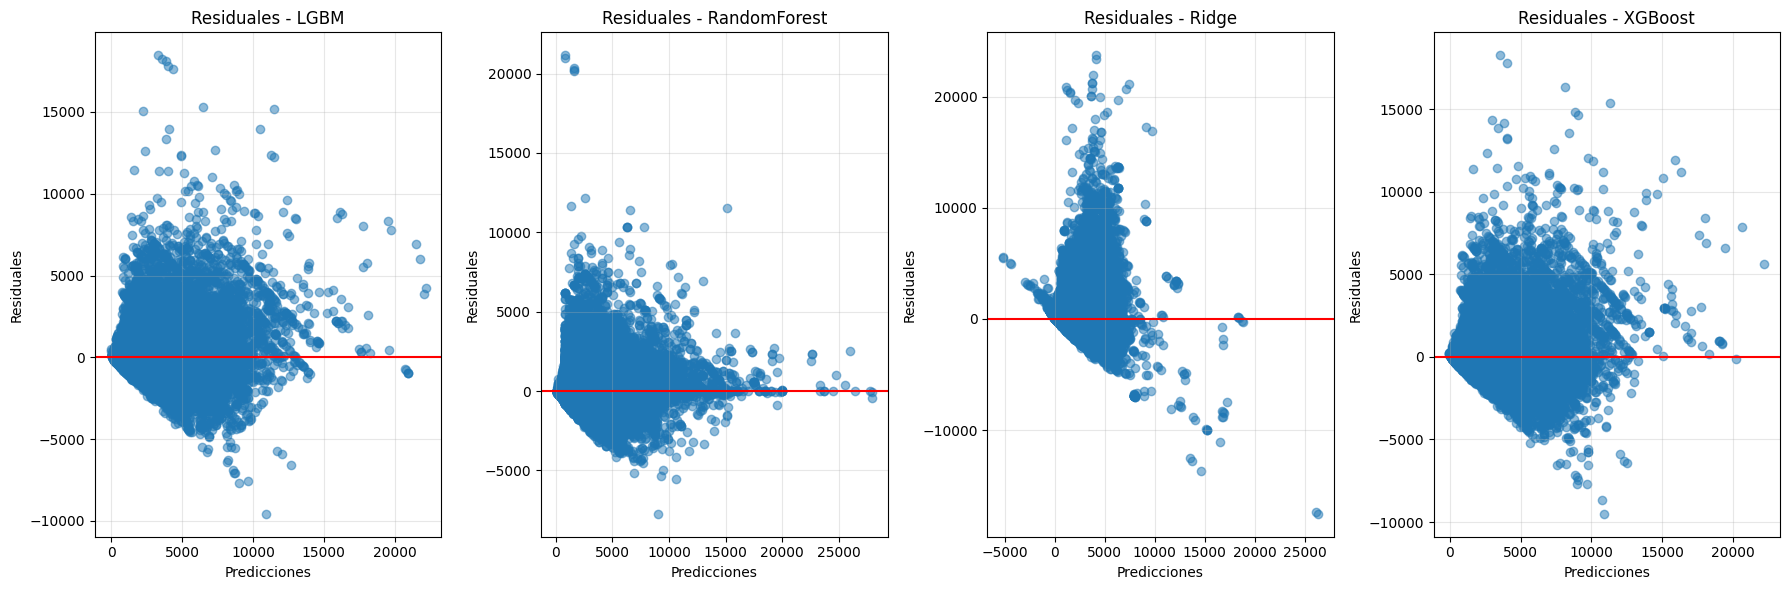

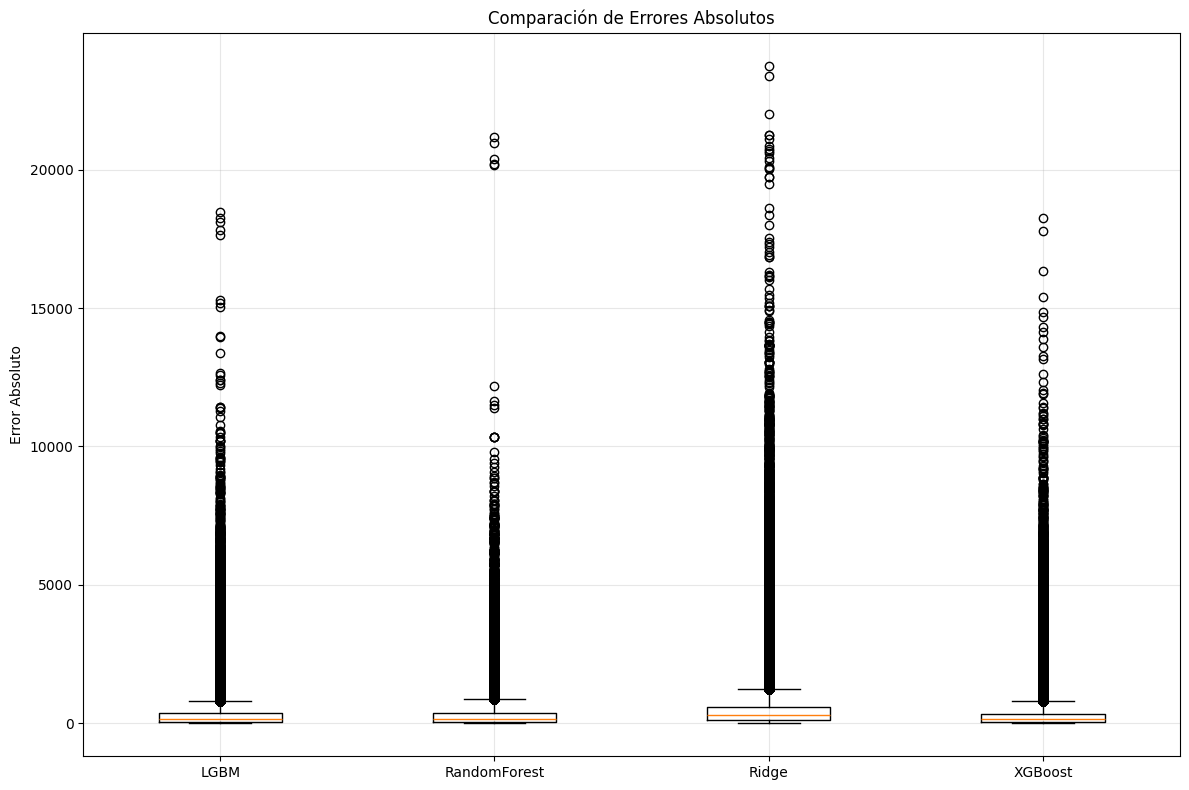

,MAE,RMSE,R²,Explained Variance,CV_MAE,CV_RMSE,CV_R²,CV_MAE_STD,CV_RMSE_STD,CV_R²_STD
LGBM,300.161190,536.270779,0.824769,0.824772,300.695957,542.490369,0.819927,0.273373,3.932860,0.001352
RandomForest,308.682804,527.175039,0.830663,0.830663,312.904741,539.659011,0.821802,0.684514,3.801859,0.001265
Ridge,463.842355,785.608390,0.623943,0.623943,463.348715,783.131729,0.624736,0.055548,3.650612,0.000875
XGBoost,296.801605,538.089167,0.823579,0.823580,297.254129,540.612735,0.821170,0.673040,5.114446,0.002134


In [52]:
# Directorio para guardar modelos
artifacts_dir = Path("./modelos/Prueba_II")

# Ejecutar entrenamiento y evaluación
metrics_df = train_evaluate_regression_models(
    models, 
    X_train_trans, 
    y_train, 
    X_val_trans, 
    y_val_raw, 
    y_scaler, 
    artifacts_dir=artifacts_dir, cv_folds=2
)

# Ver resultados comparativos
metrics_df

In [ ]:
df_filtered = df.filter(
    (df["ESTRATO"] == 4) & (df["DPTO_MPIO"] == 11001)
)
df_filtered.head()

DPTO_MPIO,ANO_CENSO,TRIMESTRE,DESTINO2,ESTADO_ACT,ESTRATO,LOCALIDAD2,AMPLIACION,OB_FORMAL,USO,USO_DOS,AREATOTZC,SIS_CONSTR,MANO_OBRAP,MANO_OBRAT,MANO_OBRAF,AREAVENDIB,NUMUNIDEST,NUMUNIVEN,NUMUNIXVEN,NRO_EDIFIC,NRO_PISOS,CAPITULO,GRADOAVANC,TIPOVRDEST,PRECIOVTAX,AREATOTCO2,AREAVENUNI,RANVIVI,LIC_RADICADO_SN,C1_EXCAVACION,C1_CIMENTACION,C1_DESAGUES,C2_ESTRUCTURA,C2_INST_HIDELEC,C2_CUBIERTA,C3_MAMPOSTERIA,C3_PANETE,C4_PISO_ENCHAPE,C4_CARP_METALICA,C4_CARP_MADERA,C4_CIELO_RASO,C5_VID_CERRAJERIA,C5_PINTURA,C6_REM_EXTERIORES,C6_REM_ACABADOS,C6_ASEO,UNI_DEC_NOVIS,UNIDEC_RANVIVI_1,UNIDEC_RANVIVI_2,UNIDEC_RANVIVI_3,UNIDEC_RANVIVI_4,UNIDEC_RANVIVI_5,UNIDEC_RANVIVI_6,AREA_RANVIVI_1,AREA_RANVIVI_2,AREA_RANVIVI_3,AREA_RANVIVI_4,AREA_RANVIVI_5,AREA_RANVIVI_6,AREA_NOVIS,MOVIMIENTO_ENC,ANIO_MESINICIO
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,f64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64
11001,2023,4,1,1,4,11,2,2,1,0,3025.0,4,1,155,0.0,11755.0,140,0,17,1,18,2,12,1,7288.928571,14780,70.035714,6,1,100.0,100.0,100.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,29.14824,29.418702,0.0,0.0,0.0,0.0,0.0,140,0,0,0,0,34,106,0.0,0.0,0.0,0.0,3589.43,11190.57,14780.0,1,2023
11001,2023,3,1,2,4,11,1,2,2,1,36.0,5,0,0,0.0,300.0,4,0,0,1,2,3,20,1,4550.0,336,75.0,5,1,100.0,100.0,100.0,100.0,100.0,100.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0,0,0,0,4,0,0.0,0.0,0.0,0.0,336.0,0.0,336.0,1,2023
11001,2014,3,3,1,4,0,2,2,2,3,40.0,1,0,8,0.0,750.0,1,0,0,1,4,2,100,1,3650.0,790,750.0,0,2,100.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2014
11001,2020,2,3,1,4,9,2,1,2,1,2000.0,1,0,100,0.0,7797.0,2,0,0,1,2,2,60,1,6000.0,9797,3898.5,0,0,100.0,100.0,100.0,60.0,10.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2019
11001,2012,3,6,3,4,0,2,1,2,3,0.0,3,0,0,0.0,1395.0,1,0,0,0,1,6,100,1,1900.0,1395,1395.0,0,0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,2011


In [57]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import randint, uniform
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# ---------- Distribuciones SIN n_estimators ----------
xgb_params = {
    "learning_rate":       uniform(0.01, 0.29),
    "max_depth":           randint(3, 11),
    "min_child_weight":    randint(1, 11),
    "gamma":               uniform(0, 5),
    "subsample":           uniform(0.5, 0.5),
    "colsample_bytree":    uniform(0.5, 0.5),
    "reg_lambda":          uniform(1e-3, 10),
    "reg_alpha":           uniform(1e-3, 10),
}

lgbm_params = {
    "learning_rate":       uniform(0.01, 0.29),
    "max_depth":           randint(-1, 13),
    "num_leaves":          randint(31, 256),
    "min_child_samples":   randint(5, 31),
    "subsample":           uniform(0.5, 0.5),
    "colsample_bytree":    uniform(0.5, 0.5),
    "reg_lambda":          uniform(1e-3, 10),
    "reg_alpha":           uniform(1e-3, 10),
}

def make_search(model, param_dist):
    return HalvingRandomSearchCV(
        model,
        param_dist,
        resource="n_estimators",
        max_resources=1200,   # valor del constructor
        min_resources=300,
        factor=2,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1,
        random_state=42,
        verbose=1,
    )

xgb_base  = XGBRegressor(n_estimators=1200, random_state=42, n_jobs=-1)
lgbm_base = LGBMRegressor(n_estimators=1200, random_state=42, n_jobs=-1)

xgb_search  = make_search(xgb_base,  xgb_params)
lgbm_search = make_search(lgbm_base, lgbm_params)

for name, search in [("XGB", xgb_search), ("LGBM", lgbm_search)]:
    search.fit(X_train_trans, y_train)
    best_params = search.best_params_
    best_score  = -search.best_score_
    print(f"{name}  MAE CV = {best_score:.2f}\n  params = {best_params}\n")


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 300
max_resources_: 1200
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 4
n_resources: 300
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 600
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
iter: 2
n_candidates: 1
n_resources: 1200
Fitting 5 folds for each of 1 candidates, totalling 5 fits
XGB  MAE CV = 0.23
  params = {'colsample_bytree': np.float64(0.5909124836035503), 'gamma': np.float64(0.9170225492671691), 'learning_rate': np.float64(0.09823025045826593), 'max_depth': 8, 'min_child_weight': 9, 'reg_alpha': np.float64(2.9132914019804192), 'reg_lambda': np.float64(6.119528947223795), 'subsample': np.float64(0.569746930326021), 'n_estimators': 1200}

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 300
max_resources_: 1200
aggressive_elimination: False
factor: 2


In [58]:
from sklearn.metrics import mean_absolute_error

best_lgbm = lgbm_search.best_estimator_
best_xgb  = xgb_search.best_estimator_

for name, model in [("LGBM", best_lgbm), ("XGB", best_xgb)]:
    preds_scaled = model.predict(X_val_trans)
    preds = y_scaler.inverse_transform(preds_scaled.reshape(-1,1)).ravel()
    mae  = mean_absolute_error(y_val_raw, preds)
    print(f"{name}  MAE hold-out = {mae:,.1f}")

c:\Users\JemyC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LGBM  MAE hold-out = 276.7
XGB  MAE hold-out = 295.0



Entrenando y evaluando LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.127724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6146
[LightGBM] [Info] Number of data points in the train set: 2221956, number of used features: 178
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

c:\Users\JemyC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Entrenando y evaluando XGBoost...


c:\Users\JemyC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\JemyC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\JemyC\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "c:\Users\JemyC\AppData\Local\Programs\Python\Pyth

<Figure size 1600x800 with 0 Axes>

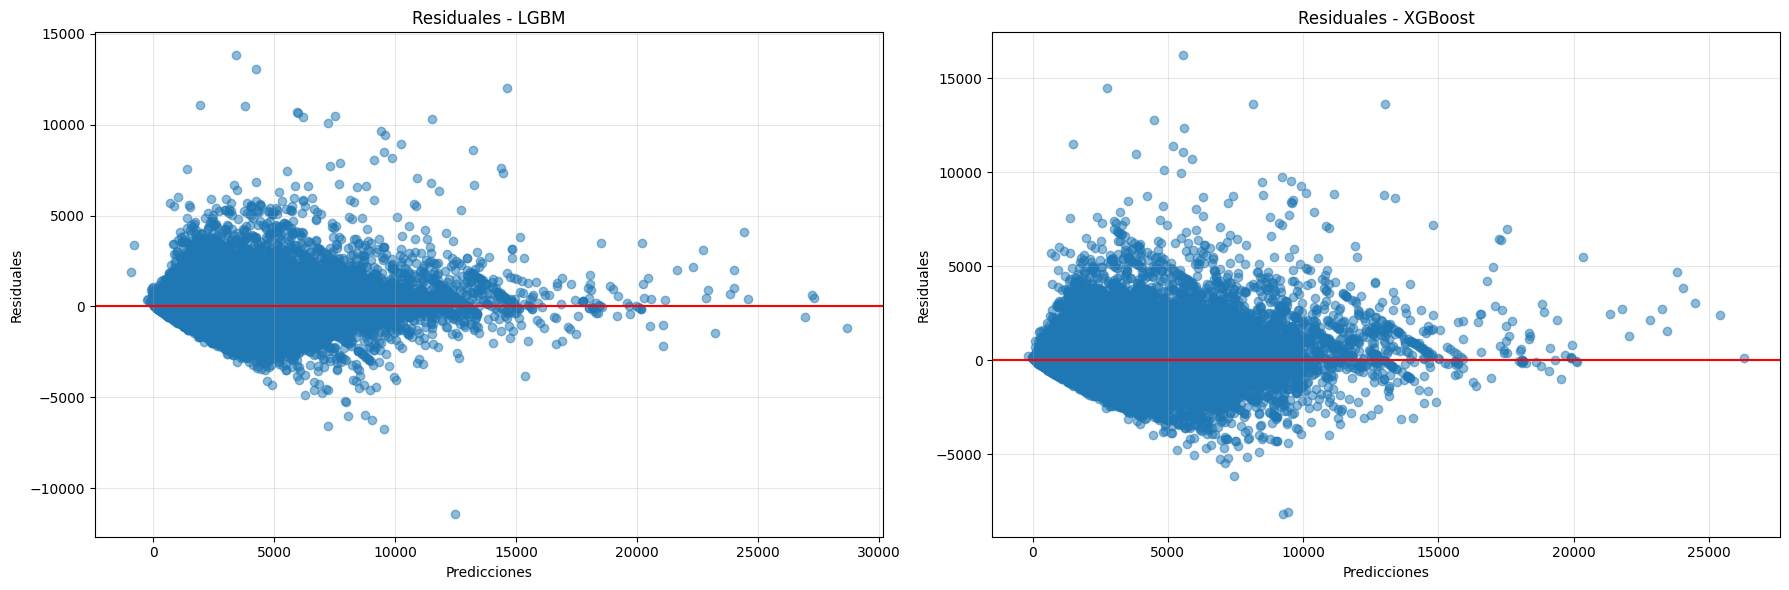

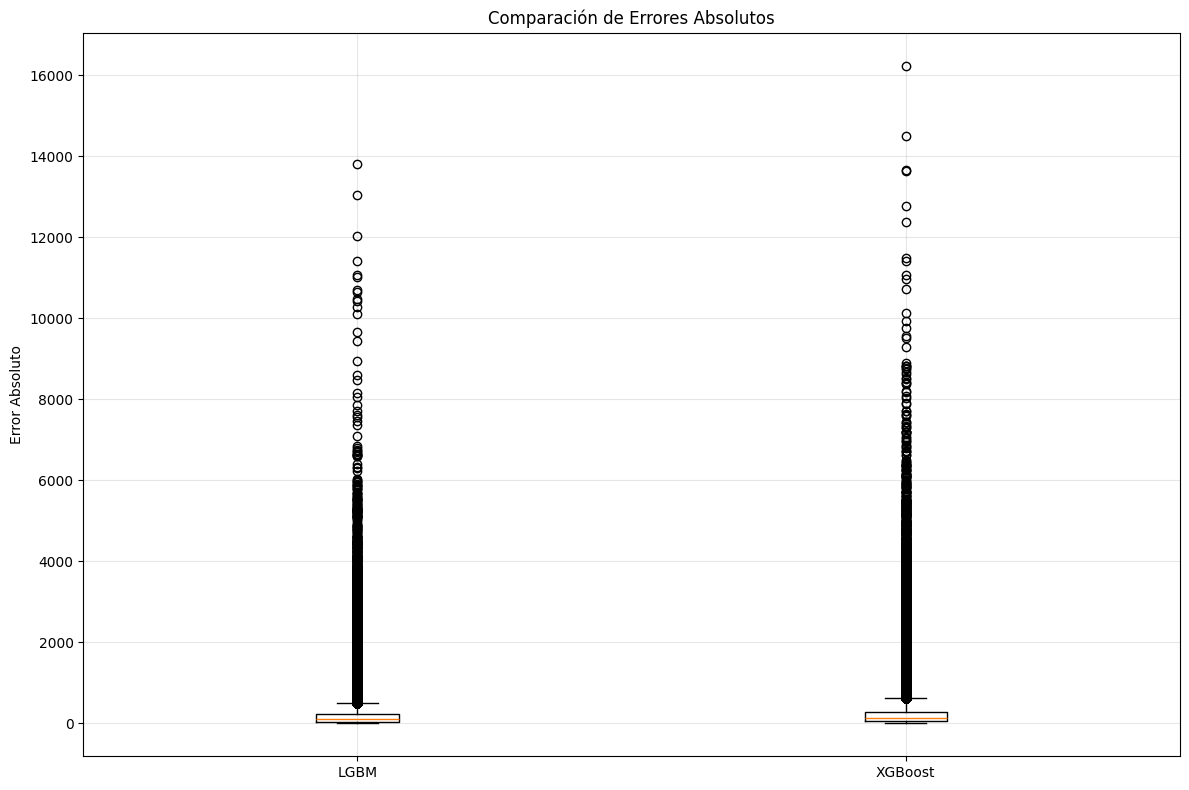

,MAE,RMSE,R²,Explained Variance,CV_MAE,CV_RMSE,CV_R²,CV_MAE_STD,CV_RMSE_STD,CV_R²_STD
LGBM,191.924346,350.050506,0.925337,0.925338,197.444394,365.34953,0.918316,0.387111,3.074178,0.001379
XGBoost,240.657588,425.072345,0.889905,0.889905,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Definir modelos
models = {
    "LGBM": LGBMRegressor(n_estimators=1200, learning_rate=0.286, min_child_samples=12, max_depth=9, num_leaves=219, subsample=0.56, colsample_bytree=0.8, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=1200, learning_rate=0.098, min_child_weight=9, max_depth=8, subsample=0.54, colsample_bytree=0.8, random_state=42, n_jobs=-1)
}

# Directorio para guardar modelos
artifacts_dir = Path("./modelos/Prueba_II_Best")

# Ejecutar entrenamiento y evaluación
metrics_df = train_evaluate_regression_models(
    models, 
    X_train_trans, 
    y_train, 
    X_val_trans, 
    y_val_raw, 
    y_scaler, 
    artifacts_dir=artifacts_dir, cv_folds=5
)

# Ver resultados comparativos
metrics_df